In [ ]:
import os
from google.colab import drive

# Mount Google Drive
drive.mount("/content/drive")

%cd "/content/drive/MyDrive/CS5780/P8_MLP&CNN_Handwritten Digits Classification"

# Verify the current working directory
print("Current working directory:", os.getcwd())

# List the contents of the folder
folder_contents = os.listdir()
print(folder_contents)


<!--announcements-->
<center>
    <img src="network.png" width="400px" /></a>
</center>

<h2>Introduction</h2>

In this project, you will implement a some neural networks to solve regression and image classification problems. This project will introduce you to some of the basics of implementing and training these powerful models. For this, we will be exploring more into the deep end with Course staffs' favorite ML framework: PyTorch!

For full documentation and details, here is their site https://pytorch.org/. PyTorch is an open source machine learning library based on the Torch library, used for applications such as computer vision and natural language processing, primarily developed by Facebook's AI Research lab. Pytorch is very neat because, as you have seen your assignments, in order to do gradient descent we've had to calculate gradient manually. No more! Pytorch performs automatic differentation, as long as we use their functions in our code.

From this project, we will be implementing two neural network models learned in class:
* Multi-Layer Perceptrons
* Convolutional Neural Networks

We will also implement a __training loop__ and __testing loop__ in PyTorch for a handwriting classification task, MNIST.

Note: Because we are working with Pytorch functions and Modules, we will be using excusively Pytorch tensors instead of numpy arrays. Let's begin by importing some of the necessary functions.

In [ ]:
%matplotlib notebook

#<GRADED>
import numpy as np
from numpy.matlib import repmat
import sys
import time
import matplotlib
import matplotlib.pyplot as plt
import ipywidgets as widgets

from scipy.stats import linregress

# new torch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# new vision-dataset-related torch imports
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms

# misc imports
import random

from tqdm import tqdm
#</GRADED>

<h2>Regression on Non-linear Functions</h2>

Recall from Project 6, where you were tasked to use gradient descent to find the parameters of a simple linear regression problem. We will re-visit the regression problem, but this time for _nonlinear_ data!

Before, we were able to model a simple linear function. Let's see if we can move onto a more complex function. Let's begin by generating some data for the sine function, $y=\sin (x).$

In [ ]:
def gen_nonlinear_data(num_samples=10000):
    # generate random x samples for training and test sets
    xTr = torch.rand(num_samples, 1) * 2 * np.pi
    xTe = torch.rand(int(num_samples * 0.1), 1) * 2 * np.pi

    # gaussian noise for non-linear regression
    noise = torch.rand(num_samples, 1) * 0.2
    test_noise = torch.rand(int(num_samples * 0.1), 1) * 0.2

    # add noise on the labels for the training set
    yTr = torch.sin(xTr) + noise
    yTe = torch.sin(xTe) + test_noise
    return xTr, xTe, yTr, yTe

In [ ]:
nl_xTr, nl_xTe, nl_yTr, nl_yTe = gen_nonlinear_data(num_samples=500)

Recall the <code>LinearRegressionModel</code> implemented in Project 6. We have copied it below (no need to re-implement it). As a reminder, PyTorch models inherit the class torch.nn.module, and you feed in a batch of $n$ samples as input and you get batch of outputs. Every torch module will implement two functions. __init__ as its constructor, and __forward__ function, which defines what happens when you call the module.

For the regression task, we use our familiar mean-squared error loss.

In [ ]:
class LinearRegressionModel(nn.Module):
    def __init__(self, ndims):
        super(LinearRegressionModel, self).__init__()
        """ pytorch optimizer checks for the properties of the model, and if
            the torch.nn.Parameter requires gradient, then the model will update
            the parameters automatically.
        """
        self.w = nn.Parameter(torch.randn(ndims, 1), requires_grad=True)
        self.b = nn.Parameter(torch.randn(1), requires_grad=True)

    def forward(self, x):
        return x @ self.w + self.b

def mse_loss(y_pred, y_true):
    square_diff = torch.pow((y_pred-y_true), 2)
    mean_error = 0.5 * torch.mean(square_diff)
    return mean_error

Here is a regression training loop in Pytorch, similar to the one from Project 6. We have supplied comments per line to help walk you through what each different part does.

In [ ]:
def train_regression_model(xTr, yTr, model, num_epochs, lr=1e-2, print_freq=100, display_loss=True):
    """Train loop for a neural network model. Please use the Adam optimizer, optim.Adam.

    Input:
        xTr:     (n, d) matrix of regression input data
        yTr:     n-dimensional vector of regression labels
        model:   nn.Model to be trained
        num_epochs: number of epochs to train the model for
        lr:      learning rate for the optimizer
        print_freq: frequency to display the loss
        display_loss: boolean, if we print the loss

    Output:
        model:   nn.Module trained model
    """
    optimizer = optim.Adam(model.parameters(), lr=lr)  # create an Adam optimizer for the model parameters

    for epoch in range(num_epochs):
        # need to zero the gradients in the optimizer so we don't
        # use the gradients from previous iterations
        optimizer.zero_grad()
        pred = model(xTr)  # run the forward pass through the model to compute predictions
        loss = mse_loss(pred, yTr)
        loss.backward()  # compute the gradient wrt loss
        optimizer.step()  # performs a step of gradient descent
        if display_loss and (epoch + 1) % print_freq == 0:
            print('epoch {} loss {}'.format(epoch+1, loss.item()))

    return model  # return trained model

Let's begin by seeing what happens when we run our linear model, <code>LinearRegressionModel</code>, on this data. Run the train loop as before on this new data, and plot the results. Visualize how good of a fit our line is to the data.

epoch 500 loss 0.47751355171203613
epoch 1000 loss 0.20609885454177856
epoch 1500 loss 0.11634070426225662
epoch 2000 loss 0.10174261778593063
avg test error 0.10330131649971008


<IPython.core.display.Javascript object>


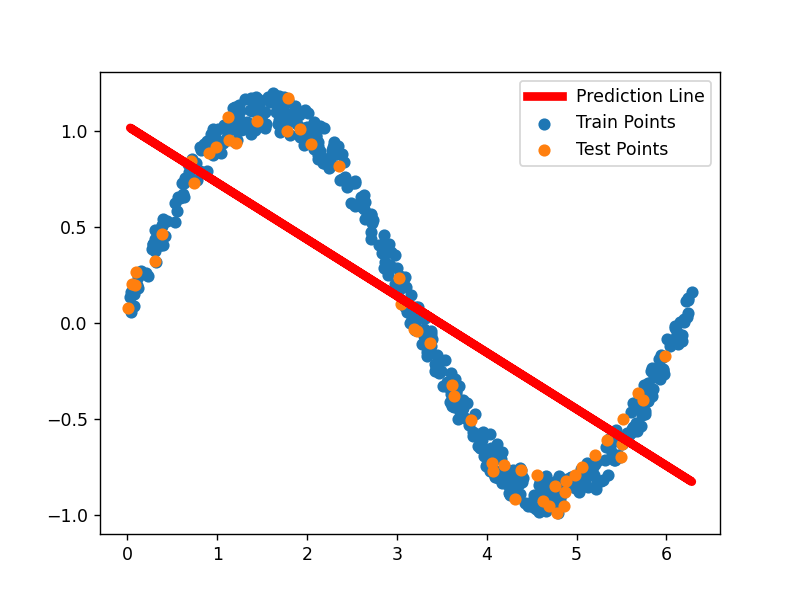

In [ ]:
ndims = nl_xTr.shape[1]
linear_model = LinearRegressionModel(ndims)  # initialize the model
linear_model = train_regression_model(nl_xTr, nl_yTr,
                                      linear_model,
                                      num_epochs=2000,
                                      lr=1e-2,
                                      print_freq=500)
avg_test_error = mse_loss(linear_model(nl_xTe), nl_yTe)  # compute the average test error
print('avg test error', avg_test_error.item())

# Visualize the results
plt.figure()
plt.plot(nl_xTr, linear_model(nl_xTr).detach(),linewidth=5.0, color="red", label="Prediction Line")
plt.scatter(nl_xTr, nl_yTr, label="Train Points")
plt.scatter(nl_xTe, nl_yTe, label="Test Points")
plt.legend()
plt.show()

Needless to say, a linear model doesn't model a sine function very well! Let's instead use our first neural network, a __Multi-Layer Perceptron model__.

We need to define a few layers of the <code>MLPNet</code> using Pytorch, and implement the forward pass. For this network, write an MLP that has:
* Two fully connected layers: Use the Pytorch implementation, <code>nn.Linear(in_dim, out_dim)</code>. This will be updated automatically by Pytorch in our training loop.
* ReLU nonlinearities: Use the Pytorch implementation, <code>nn.functional.relu</code> between each of the linear layers.

In [ ]:
# # Create a Pytorch Multilayer Perceptron (MLP) Model
# #<GRADED>
# class MLPNet(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim=1):
#         super(MLPNet, self).__init__()
#         """ pytorch optimizer checks for the properties of the model, and if
#             the torch.nn.Parameter requires gradient, then the model will update
#             the parameters automatically.
#         """
#         self.input_dim = input_dim
#         self.hidden_dim = hidden_dim
#         self.output_dim = output_dim

#         # Initialize the fully connected layers
#         self.fc1 = nn.Linear(in_features=self.input_dim, out_features=self.hidden_dim)
#         self.fc2 = nn.Linear(in_features=self.hidden_dim, out_features=self.output_dim)

# #         raise NotImplementedError("Your code goes here!")


#     def forward(self, x):
#         # Implement the forward pass, with ReLU non-linearities
# #         raise NotImplementedError("Your code goes here!")
#         x = nn.Flatten()(x)
#         x = self.fc1(x)
#         x = nn.functional.relu(x)
#         x = self.fc2(x)
#         x = nn.functional.relu(x)

#         return x
# #</GRADED>

In [ ]:
# Create a Pytorch Multilayer Perceptron (MLP) Model
#<GRADED>
class MLPNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLPNet, self).__init__()
        # First fully connected layer
        self.fc1 = nn.Linear(input_dim, hidden_dim)

        # Second fully connected layer
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = nn.Flatten()(x)

        # Apply first layer with ReLU
        x = F.relu(self.fc1(x))

        # Apply second layer
        x = self.fc2(x)

        return x
#</GRADED>

How does the __hidden dimensions__ in an MLP affect the output results? Try out various hidden dimensions using the code provided. We highly recommend for you to play with different number of hidden nodes using the slider tool. Do more or less hidden nodes result in smoother regression outputs? What is the tradeoff?

<IPython.core.display.Javascript object>


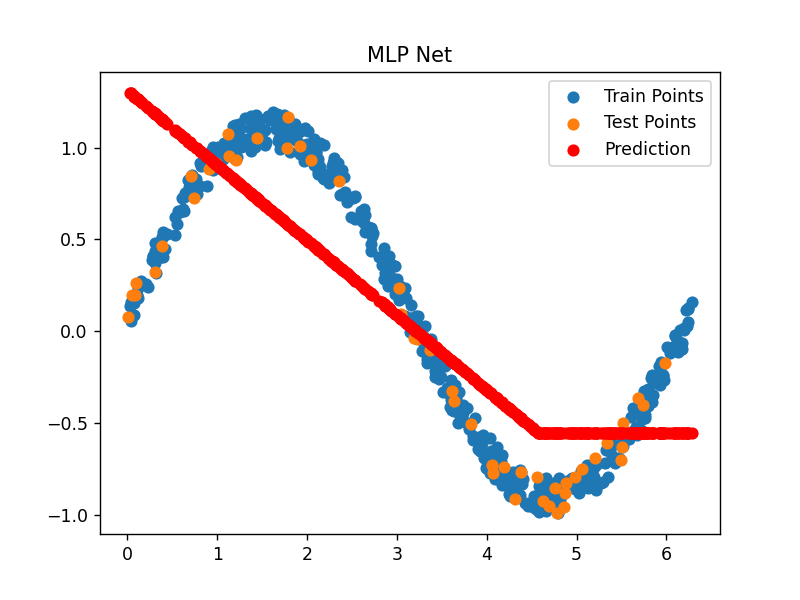

interactive(children=(IntSlider(value=1, description='hdims', max=200, min=1), Output()), _dom_classes=('widge…

In [ ]:
num_epochs = 2000
lr = 1e-3
trained_models = {}

fig = plt.figure()

def update(hdims):
    fig.clear()
    key = str(hdims)
    if key in trained_models:
        mlp_model = trained_models[key]
    else:
        mlp_model = MLPNet(input_dim=1, hidden_dim=hdims, output_dim=1)
        mlp_model = train_regression_model(nl_xTr, nl_yTr, mlp_model, num_epochs=num_epochs, lr=lr, display_loss=False)
        trained_models[key] = mlp_model
    plt.scatter(nl_xTr, nl_yTr, label="Train Points")
    plt.scatter(nl_xTe, nl_yTe, label="Test Points")
    plt.title('MLP Net')
    plt.scatter(nl_xTr, mlp_model(nl_xTr).detach(), color="red", marker='o', label="Prediction")
    plt.legend()
    fig.canvas.draw()

widgets.interact(update, hdims=widgets.IntSlider(value=1, min=1, max=200, step=1));

Run the regression train loop, <code>train_regression_model</code>, with the MLP model on the non-linear data. Use your favorite hidden dimension <code>hdim</code> from above to get the test error below 0.002. Additionally, what learning rates and number of epochs converges for the MLP model? To start, we suggest using <code>num_epochs = 5000</code>, and <code>lr = 1e-3</code>.

In [ ]:
hdims = 100
num_epochs = 5000
lr = 0.001

mlp_model = MLPNet(input_dim=1, hidden_dim=hdims, output_dim=1)
mlp_model = train_regression_model(nl_xTr, nl_yTr, mlp_model, num_epochs=num_epochs, lr=lr)
avg_test_error = mse_loss(mlp_model(nl_xTe), nl_yTe)
print('avg test error', avg_test_error.item())

epoch 100 loss 0.09238844364881516
epoch 200 loss 0.05717629939317703
epoch 300 loss 0.04909820482134819
epoch 400 loss 0.04283834621310234
epoch 500 loss 0.03705630078911781
epoch 600 loss 0.03169848024845123
epoch 700 loss 0.026863975450396538
epoch 800 loss 0.022453125566244125
epoch 900 loss 0.01836259290575981
epoch 1000 loss 0.014503469690680504
epoch 1100 loss 0.010566821321845055
epoch 1200 loss 0.007952510379254818
epoch 1300 loss 0.006103176157921553
epoch 1400 loss 0.0047606234438717365
epoch 1500 loss 0.00376274180598557
epoch 1600 loss 0.0031552589498460293
epoch 1700 loss 0.0027323870453983545
epoch 1800 loss 0.002456309273838997
epoch 1900 loss 0.002262103371322155
epoch 2000 loss 0.002123841317370534
epoch 2100 loss 0.0019928899127990007
epoch 2200 loss 0.0018978333100676537
epoch 2300 loss 0.001821032608859241
epoch 2400 loss 0.0017646276392042637
epoch 2500 loss 0.0017208621138706803
epoch 2600 loss 0.00168512889649719
epoch 2700 loss 0.0016339566791430116
epoch 2800 

Now, we have trained our first neural network model! Let's predict by passing in input data via <code>mlp_model(x)</code>.

Visualize how good of a fit our MLP is to the data, as compared to the linear model via a side-by-side comparison:

<IPython.core.display.Javascript object>


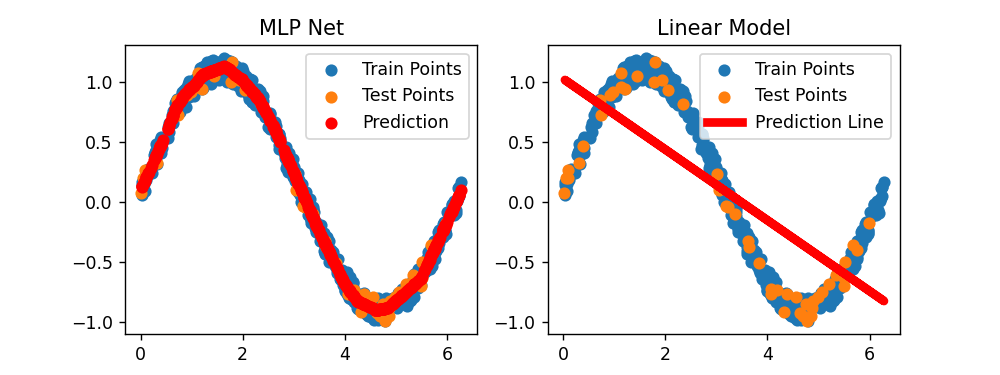

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3))

# Plot the visualizations from our MLP Model
ax1.scatter(nl_xTr, nl_yTr, label="Train Points")
ax1.scatter(nl_xTe, nl_yTe, label="Test Points")
ax1.scatter(nl_xTr, mlp_model(nl_xTr).detach(), color="red", marker='o', label="Prediction")
ax1.legend()
ax1.set_title('MLP Net')

# Plot the visualizations from our MLP Model
ax2.scatter(nl_xTr, nl_yTr, label="Train Points")
ax2.scatter(nl_xTe, nl_yTe, label="Test Points")
ax2.plot(nl_xTr, linear_model(nl_xTr).detach(),linewidth=5.0, color="red", label="Prediction Line")
ax2.legend()
ax2.set_title('Linear Model')

plt.show()

<h2>Handwritten Digits Classification</h2>

One of the tasks neural network models can solve quite well is classification! We will explore their capabilities on a simple classification task, classifying handwritten digits. Specifically, we will be taking an image of a digit between 0 - 9 and classifying which digit it is.




<center>
    <img src="320px-MnistExamples.png" width="400px" /></a>
</center>

For this task, we will look into the [MNIST dataset](http://yann.lecun.com/exdb/mnist/). The MNIST database consists of black and white handwritten digits, cropped to a fixed size. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting.

Fortunately for us, Pytorch provides an easy implementation to download the cleaned and already prepared data, using a few lines of code. Let us load it and visualize some of the images.

In [ ]:
# Load the dataset
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
train_set = dset.MNIST(root=".", train=True, transform=trans, download=True)
train_subset_indices = np.load("train_subset_indices.npy")  # load a predefined subset for efficiency
train_set = torch.utils.data.Subset(train_set, train_subset_indices)
test_set = dset.MNIST(root=".", train=False, transform=trans, download=True)

batch_size = 64

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)

<IPython.core.display.Javascript object>


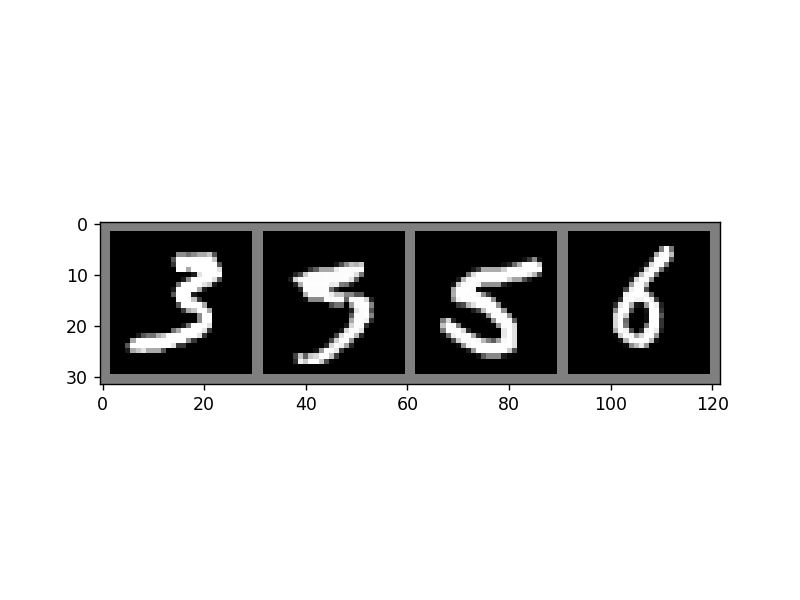

labels are: 3 3 5 6


In [ ]:
def imshow(img):
    img = img + 0.5     # unnormalize
    plt.figure()
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = dataiter.next()

num_show_img = 4
# show images
imshow(torchvision.utils.make_grid(images[:num_show_img]))
# print labels
print('labels are:', ' '.join('%d' % labels[j] for j in range(num_show_img)))

Update the regression train loop (given above in <code>train_regression_model</code>) to train a classification model instead. The key difference is the loss function used is _no longer the MSE loss_.

We will instead use the cross entropy loss, which is implemented for us in Pytorch, <code>nn.functional.cross_entropy(predictions, labels)</code>. Implement the new training loop, <code>train_classification_model</code>, and assume that the prediction outputs from the model are in one-hot format.

In [ ]:
# Training function
#<GRADED>
def train_classification_model(train_loader, model, num_epochs, lr=1e-1, print_freq=100):
    """Train loop for a neural network model. Please use the SGD optimizer, optim.SGD.

    Input:
        train_loader:    Data loader for the train set.
                         Enumerate through to train with each batch.
        model:           nn.Model to be trained
        num_epochs:      number of epochs to train the model for
        lr:              learning rate for the optimizer
        print_freq:      frequency to display the loss

    Output:
        model:   nn.Module trained model
    """
    optimizer = optim.SGD(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        model.train()

        # Iterate through the dataloader for each epoch
        for batch_idx, (imgs, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            pred = model(imgs)
            loss = criterion(pred, labels)
            loss.backward()  # compute the gradient wrt loss
            optimizer.step()  # performs a step of gradient descent

            if batch_idx % print_freq == 0:
                print(f'Epoch {epoch + 1}/{num_epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item()}')
    return model
#</GRADED>

In [ ]:
# def train_classification_model(train_loader, model, num_epochs, lr=1e-1, print_freq=100):
#     """Train loop for a neural network model. Please use the SGD optimizer, optim.SGD.

#     Input:
#         train_loader:    Data loader for the train set.
#                          Enumerate through to train with each batch.
#         model:           nn.Model to be trained
#         num_epochs:      number of epochs to train the model for
#         lr:              learning rate for the optimizer
#         print_freq:      frequency to display the loss

#     Output:
#         model:   nn.Module trained model
#     """
#     optimizer = optim.SGD(model.parameters(), lr=lr)  # create an SGD optimizer for the model parameters
#     for epoch in range(num_epochs):
#         model.train()

#         # Iterate through the dataloader for each epoch
#         for batch_idx, (imgs, labels) in enumerate(train_loader):
#             # imgs (torch.Tensor):    batch of input images [64, 1, 28, 28]
#             # labels (torch.Tensor):  batch labels corresponding to the inputs

#             # Implement the training loop using imgs, labels, and cross entropy loss
#             # raise NotImplementedError("Your code goes here!")

#             optimizer.zero_grad()
# #             print(f'imgs.shape: {imgs.shape}') # torch.Size([64, 1, 28, 28])
# #             imgs = imgs.view(-1, 28 * 28)
# #             print(f'imgs.shape: {imgs.shape}') # imgs.shape: torch.Size([64, 784])
# #             print(f'labels.shape: {labels.shape}')
#             pred = model(imgs)  # run the forward pass through the model to compute predictions
# #             print(f'pred.shape: {pred.shape}')
#             loss = nn.functional.cross_entropy(pred, labels)
#             loss.backward()  # compute the gradient wrt loss
#             optimizer.step()  # performs a step of gradient descent

#     return model  # return trained model

In [ ]:
# def train_classification_model(train_loader, model, num_epochs, lr=1e-1, print_freq=100):
#     """Train loop for a neural network model with progress bar. Uses the SGD optimizer.

#     Input:
#         train_loader: Data loader for the train set.
#                       Enumerate through to train with each batch.
#         model:        nn.Module to be trained
#         num_epochs:   Number of epochs to train the model for
#         lr:           Learning rate for the optimizer
#         print_freq:   Frequency to display the loss

#     Output:
#         model: Trained nn.Module model
#     """
#     optimizer = optim.SGD(model.parameters(), lr=lr)
#     for epoch in range(num_epochs):
#         model.train()

#         # Wrap the train_loader with tqdm for a progress bar
#         progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
#         for batch_idx, (imgs, labels) in progress_bar:
#             pred = model(imgs)
#             loss = nn.functional.cross_entropy(pred, labels)

#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#             # Update progress bar with loss info
#             if batch_idx % print_freq == 0:
#                 progress_bar.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
#                 progress_bar.set_postfix(loss=loss.item())

#     return model


In [ ]:
def train_classification_model(train_loader, model, num_epochs, lr=1e-1, print_freq=100):
    """Train loop for a neural network model for classification using cross-entropy loss.

    Args:
        train_loader (DataLoader): Data loader for the training set.
        model (nn.Module): Neural network model to be trained.
        num_epochs (int): Number of epochs to train the model.
        lr (float): Learning rate for the optimizer.
        print_freq (int): Frequency (in iterations) to print the loss.

    Returns:
        nn.Module: Trained model.
    """
    # Initialize the optimizer
    optimizer = optim.SGD(model.parameters(), lr=lr)

    # Train the model
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0.0
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad()

            # Forward pass
            predictions = model(inputs)

            # Compute loss - assumes predictions are logits and labels are indices
            loss = F.cross_entropy(predictions, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Print loss every `print_freq` batches
            if (batch_idx + 1) % print_freq == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {total_loss/len(train_loader):.4f}')

    return model


Additionally, implement the classification test function. Compute the accuracy of our model over the test set. We say that the predicted label is the digit that the model outputs the _maximum score_, and a correct prediction is one where the maximum score matches the true label. Return the average accuracy over all batches in the test set.

In [ ]:
# Test function
#<GRADED>
def test_classification_model(test_loader, model):
    """Tests the accuracy of the model.

    Input:
        test_loader:      Data loader for the test set.
                          Enumerate through to test each example.
        model:            nn.Module model being evaluate.

    Output:
        accuracy:         Accuracy of the model on the test set.
    """
    # Compute the model accuracy
    model.eval()
    accuracy = 0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for batch_idx, (imgs, labels) in enumerate(test_loader):
            Y_pred_prob = model(imgs)
#             Y_pred = torch.argmax(Y_pred_prob, dim=1)
            _, Y_pred = torch.max(Y_pred_prob, 1)
#             total_correct += torch.sum(Y_pred == labels).item()
            total_correct += (Y_pred == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = total_correct / total_samples
    return accuracy
#</GRADED>

In [ ]:
def test_classification_model(test_loader, model):
    """Tests the accuracy of the model on the test set.

    Args:
        test_loader (DataLoader): Data loader for the test set.
        model (nn.Module): Model to be evaluated.

    Returns:
        float: Accuracy of the model on the test set.
    """
    # Ensure the model is in evaluation mode
    model.eval()

    correct = 0
    total = 0

    # No need to track gradients for testing
    with torch.no_grad():
        for inputs, labels in test_loader:
            # Forward pass
            outputs = model(inputs)

            # Get the predictions
            _, predicted = torch.max(outputs.data, 1)

            # Update totals and correct counts
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate accuracy
    accuracy = correct / total
    print(f"Model Accuracy on Test Set: {accuracy * 100:.2f}%")

    return accuracy


Finally, we are ready to train an MLP neural network on this classification task! Initialize a <code>MLPNet</code> with the proper input dimension and output dimension. Play around with the hidden dimension to get the accuracy above 95\%. Additionally, what learning rates and number of epochs converges for the MLP model? To start, we suggest using <code>num_epochs = 40</code> and <code>lr = 1e-2</code>.

In [ ]:
# Train an MLP model on MNSIT
hidden_dim = 256
num_epochs = 10
lr = 1e-3

mlp_model = MLPNet(input_dim=28*28, hidden_dim=hidden_dim, output_dim=10)
print('the number of parameters', sum(parameter.view(-1).size()[0] for parameter in mlp_model.parameters()))
mlp_model = train_classification_model(train_loader, mlp_model, num_epochs=num_epochs, lr=lr)
avg_test_acc = test_classification_model(test_loader, mlp_model)
print('avg test accuracy', avg_test_acc)

the number of parameters 203530
Epoch [1/10], Step [100/157], Loss: 2.2822
Epoch [1/10], Average Loss: 2.2882
Epoch [2/10], Step [100/157], Loss: 2.2355
Epoch [2/10], Average Loss: 2.2444
Epoch [3/10], Step [100/157], Loss: 2.2138
Epoch [3/10], Average Loss: 2.2037
Epoch [4/10], Step [100/157], Loss: 2.1697
Epoch [4/10], Average Loss: 2.1636
Epoch [5/10], Step [100/157], Loss: 2.1201
Epoch [5/10], Average Loss: 2.1199
Epoch [6/10], Step [100/157], Loss: 2.0377
Epoch [6/10], Average Loss: 2.0749
Epoch [7/10], Step [100/157], Loss: 2.0510
Epoch [7/10], Average Loss: 2.0271
Epoch [8/10], Step [100/157], Loss: 1.9904
Epoch [8/10], Average Loss: 1.9783
Epoch [9/10], Step [100/157], Loss: 1.9613
Epoch [9/10], Average Loss: 1.9273
Epoch [10/10], Step [100/157], Loss: 1.8635
Epoch [10/10], Average Loss: 1.8739
Model Accuracy on Test Set: 66.47%
avg test accuracy 0.6647


<h3>Convolutional Neural Networks</h3>

In class, we learned about about Convolutional Neural Networks (or CNN for short) that is explicity designed for image inputs. Let's implement and train a CNN on the MNIST dataset!

We need to define a few layers of the <code>ConvNet</code> using Pytorch, and implement the forward pass. For this network, write an CNN that has:
* Two convolutional layers: Use the Pytorch implementation, <code>nn.Conv2d(in_channels, out_channels)</code>. For each convolutional layer, set <code>kernel_size=3</code>, <code>stride=1</code>, <code>padding=1</code> and <code>bias=False</code>.
* ReLU nonlinearities: Use the Pytorch implementation, <code>nn.functional.relu</code> between each of the layers.
* Max-Pooling layers: Use the Pytorch implementation, <code>nn.functional.max_pool2d</code> to pool after each of the ReLU. For each max-pooling layer, set <code>kernel_size=2</code>, <code>stride=2</code>.
* Last layer a fully connected layer: Use the Pytorch implementation, <code>nn.Linear(in_dim, out_dim)</code>. <code>in_dim</code> depends on the size of input image (MNIST images), which is <code>28 * 28</code> in our case. Make sure to re-shape the input into a batch of vectors to pass it through the last layer using the function: <code>Tensor.view(*shape)</code>.

In [ ]:
# Create Pytorch ConvNet Model
#<GRADED>
class ConvNet(nn.Module):
    def __init__(self, input_channels=1, hidden_channels=32, output_dim=1):
        super(ConvNet, self).__init__()

        # Initialize the ConvNet layers
#         raise NotImplementedError("Your code goes here!")
        self.conv1 = nn.Conv2d(
            in_channels=input_channels,
            out_channels=hidden_channels,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False
        )
        self.conv2 = nn.Conv2d(
            in_channels=hidden_channels,
            out_channels=hidden_channels,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False
        )
        self.fc = nn.Linear(hidden_channels * 7 * 7, output_dim)


    def forward(self, x):
        # Implement the forward pass, with ReLU non-linearities and max-pooling
#         raise NotImplementedError("Your code goes here!")

        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, kernel_size=2, stride=2)
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, kernel_size=2, stride=2)

        # Reshape the output before passing through the fully connected layer
        x = x.view(x.size(0), -1)

        # Fully connected layer
        x = self.fc(x)


        return x
#</GRADED>

In [ ]:
class ConvNet(nn.Module):
    def __init__(self, input_channels=1, hidden_channels=32, output_dim=10):
        super(ConvNet, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=hidden_channels,
                               kernel_size=3, stride=1, padding=1, bias=False)

        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=hidden_channels, out_channels=hidden_channels * 2,
                               kernel_size=3, stride=1, padding=1, bias=False)

        # Fully connected layer
        # The input dimension is determined by the output of the last max-pooling layer
        self.fc = nn.Linear(hidden_channels * 2 * 7 * 7, output_dim)

    def forward(self, x):
        # Apply first convolution, followed by ReLU and max-pooling
        x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=2, stride=2)

        # Apply second convolution, followed by ReLU and max-pooling
        x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=2, stride=2)

        # Flatten the tensor for the fully connected layer
        # Use x.view() to reshape x to the correct shape for the linear layer
        x = x.view(x.size(0), -1)

        # Apply the fully connected layer
        x = self.fc(x)

        return x


Run the classificiation train loop, this time with the <code>ConvNet</code> implemented above. Try out different hidden channel dimension to obtain an accuracy above 95\%. (Hint: the channel dimension should not be above 50 for computational efficiency.)

Once again, what learning rates and number of epochs converges for the CNN model? To start, we suggest using <code>num_epochs = 40</code> and <code>lr = 1e-3</code>.

In [ ]:
# Train a convnet model on MNIST
hidden_channels = 50
num_epochs = 40
lr = 1e-3

conv_model = ConvNet(input_channels=1, hidden_channels=hidden_channels, output_dim=10)
print('the number of parameters:', sum(parameter.view(-1).size()[0] for parameter in conv_model.parameters()))
conv_model = train_classification_model(train_loader, conv_model, num_epochs=num_epochs, lr=lr)
avg_test_acc = test_classification_model(test_loader, conv_model)
print('avg test accuracy', avg_test_acc)

the number of parameters: 26990
Epoch [1/40], Step [100/157], Loss: 2.2914
Epoch [1/40], Average Loss: 2.2968
Epoch [2/40], Step [100/157], Loss: 2.2909
Epoch [2/40], Average Loss: 2.2839
Epoch [3/40], Step [100/157], Loss: 2.2648
Epoch [3/40], Average Loss: 2.2716
Epoch [4/40], Step [100/157], Loss: 2.2634
Epoch [4/40], Average Loss: 2.2586
Epoch [5/40], Step [100/157], Loss: 2.2349
Epoch [5/40], Average Loss: 2.2444
Epoch [6/40], Step [100/157], Loss: 2.2372
Epoch [6/40], Average Loss: 2.2286
Epoch [7/40], Step [100/157], Loss: 2.2064
Epoch [7/40], Average Loss: 2.2104
Epoch [8/40], Step [100/157], Loss: 2.1728
Epoch [8/40], Average Loss: 2.1893
Epoch [9/40], Step [100/157], Loss: 2.1557
Epoch [9/40], Average Loss: 2.1651
Epoch [10/40], Step [100/157], Loss: 2.1431
Epoch [10/40], Average Loss: 2.1373
Epoch [11/40], Step [100/157], Loss: 2.1042
Epoch [11/40], Average Loss: 2.1040
Epoch [12/40], Step [100/157], Loss: 2.0865
Epoch [12/40], Average Loss: 2.0663
Epoch [13/40], Step [100/1

<IPython.core.display.Javascript object>


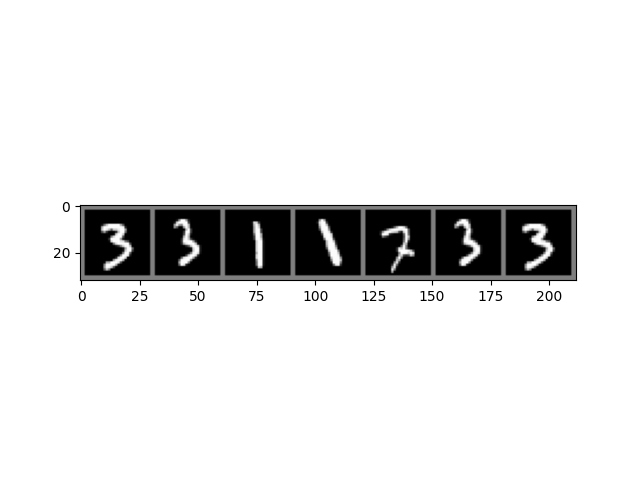

labels are: 3 3 1 1 7 3 3
MLP predictions are: 7 6 1 1 1 6 7
CNN predictions are: 3 3 1 3 7 3 3


In [ ]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

# Make a forward pass to get predictions of the MLP model
mlp_scores = mlp_model(images)
_, mlp_preds = torch.max(mlp_scores.data, 1)

# Make a forward pass to get predictions of the ConvNet model
conv_scores = conv_model(images)
_, conv_preds = torch.max(conv_scores.data, 1)

show_img_idx = np.random.randint(images.shape[0], size=7)
# show images
imshow(torchvision.utils.make_grid(images[show_img_idx]))
# print labels
print('labels are:', ' '.join('%d' % labels[j] for j in show_img_idx))
# print predictions
print('MLP predictions are:', ' '.join('%d' % mlp_preds[j] for j in show_img_idx))
print('CNN predictions are:', ' '.join('%d' % conv_preds[j] for j in show_img_idx))

<h3>Why Do CNN's Work?</h3>

Let's try to build some intuition behind why Convolution Neural Networks work well for image inputs.

For a toy experiment, let's shuffle the pixels for each of the input images, _but only in a set order_. Would we expect to see ConvNet's still working better than MLP?

In [ ]:
# Load the shuffled dataset
torch.manual_seed(0)
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
pixel_shuffle_train_set = dset.MNIST(root=".", train=True, transform=trans, download=True)
train_subset_indices = np.load("train_subset_indices.npy")  # load a subset for efficiency
pixel_shuffle_train_set = torch.utils.data.Subset(pixel_shuffle_train_set, train_subset_indices)
pixel_shuffle_test_set = dset.MNIST(root=".", train=False, transform=trans, download=True)

randperm = torch.randperm(28 * 28)
pixel_shuffle_train_set.dataset.data = pixel_shuffle_train_set.dataset.data.view(-1, 28 * 28)[:, randperm].view(-1, 28, 28)
pixel_shuffle_test_set.data = pixel_shuffle_test_set.data.view(-1, 28 * 28)[:, randperm].view(-1, 28, 28)

batch_size = 64
pixel_shuffle_train_loader = torch.utils.data.DataLoader(
                 dataset=pixel_shuffle_train_set,
                 batch_size=batch_size,
                 shuffle=True)
pixel_shuffle_test_loader = torch.utils.data.DataLoader(
                dataset=pixel_shuffle_test_set,
                batch_size=batch_size,
                shuffle=False)

<IPython.core.display.Javascript object>


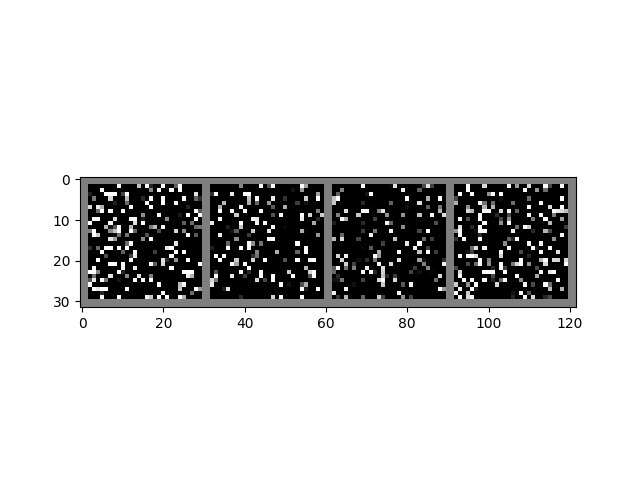

labels are: 8 4 8 5


In [ ]:
dataiter = iter(pixel_shuffle_train_loader)
images, labels = dataiter.next()

num_show_img = 4
# show shuffled images
imshow(torchvision.utils.make_grid(images[:num_show_img]))
# print labels
print('labels are:', ' '.join('%d' % labels[j] for j in range(num_show_img)))

It looks like kind of a mess! But let's train an MLP model anyways, as before, and observe the new test accuracy on this shuffled-pixel dataset. __Use the same hyperparameters as you did before__.

In [ ]:
# Train an MLP model on pixel-shuffled MNSIT
hidden_dim = 50
num_epochs = 40
lr = 1e-3

mlp_model = MLPNet(input_dim=28*28, hidden_dim=hidden_dim, output_dim=10)
print('the number of parameters:', sum(parameter.view(-1).size()[0] for parameter in mlp_model.parameters()))
mlp_model = train_classification_model(pixel_shuffle_train_loader, mlp_model, num_epochs=num_epochs, lr=lr)
avg_test_acc = test_classification_model(pixel_shuffle_test_loader, mlp_model)
print('avg test accuracy', avg_test_acc)

the number of parameters: 39760
Epoch [1/40], Step [100/157], Loss: 2.2984
Epoch [1/40], Average Loss: 2.3002
Epoch [2/40], Step [100/157], Loss: 2.2787
Epoch [2/40], Average Loss: 2.2857
Epoch [3/40], Step [100/157], Loss: 2.2798
Epoch [3/40], Average Loss: 2.2705
Epoch [4/40], Step [100/157], Loss: 2.2530
Epoch [4/40], Average Loss: 2.2540
Epoch [5/40], Step [100/157], Loss: 2.2459
Epoch [5/40], Average Loss: 2.2375
Epoch [6/40], Step [100/157], Loss: 2.2284
Epoch [6/40], Average Loss: 2.2212
Epoch [7/40], Step [100/157], Loss: 2.2495
Epoch [7/40], Average Loss: 2.2037
Epoch [8/40], Step [100/157], Loss: 2.1835
Epoch [8/40], Average Loss: 2.1849
Epoch [9/40], Step [100/157], Loss: 2.1261
Epoch [9/40], Average Loss: 2.1656
Epoch [10/40], Step [100/157], Loss: 2.1084
Epoch [10/40], Average Loss: 2.1442
Epoch [11/40], Step [100/157], Loss: 2.1352
Epoch [11/40], Average Loss: 2.1200
Epoch [12/40], Step [100/157], Loss: 2.0978
Epoch [12/40], Average Loss: 2.0954
Epoch [13/40], Step [100/1

Additionally, train a CNN model, as before, and observe the new test accuracy on this shuffled-pixel dataset. __Use the same hyperparameters as you did before__.

In [ ]:
# Train a ConvNet model on pixel-shuffled MNSIT
hidden_channels = 50
num_epochs = 40
lr = 1e-3

conv_model = ConvNet(input_channels=1, hidden_channels=hidden_channels, output_dim=10)
print('the number of parameters:', sum(parameter.view(-1).size()[0] for parameter in conv_model.parameters()))
conv_model = train_classification_model(pixel_shuffle_train_loader, conv_model, num_epochs=num_epochs, lr=lr)
avg_test_acc = test_classification_model(pixel_shuffle_test_loader, conv_model)
print('avg test accuracy', avg_test_acc)

the number of parameters: 94460
Epoch [1/40], Step [100/157], Loss: 2.2884
Epoch [1/40], Average Loss: 2.2987
Epoch [2/40], Step [100/157], Loss: 2.2819
Epoch [2/40], Average Loss: 2.2815
Epoch [3/40], Step [100/157], Loss: 2.2501
Epoch [3/40], Average Loss: 2.2650
Epoch [4/40], Step [100/157], Loss: 2.2542
Epoch [4/40], Average Loss: 2.2480
Epoch [5/40], Step [100/157], Loss: 2.2131
Epoch [5/40], Average Loss: 2.2301
Epoch [6/40], Step [100/157], Loss: 2.2317
Epoch [6/40], Average Loss: 2.2117
Epoch [7/40], Step [100/157], Loss: 2.1757
Epoch [7/40], Average Loss: 2.1910
Epoch [8/40], Step [100/157], Loss: 2.1818
Epoch [8/40], Average Loss: 2.1693
Epoch [9/40], Step [100/157], Loss: 2.1397
Epoch [9/40], Average Loss: 2.1455
Epoch [10/40], Step [100/157], Loss: 2.1282
Epoch [10/40], Average Loss: 2.1200
Epoch [11/40], Step [100/157], Loss: 2.0916
Epoch [11/40], Average Loss: 2.0930
Epoch [12/40], Step [100/157], Loss: 2.0654
Epoch [12/40], Average Loss: 2.0627
Epoch [13/40], Step [100/1

Observe that the accuracy is now _slightly lower than_ that of MLP models! This shows that CNN's utilize the stucture of the image (i.e., pixel proximity) to make their predictions. With the pixel orders shuffled, it is no longer as good of a model.

Let us visualize some of the prediction results.

<IPython.core.display.Javascript object>


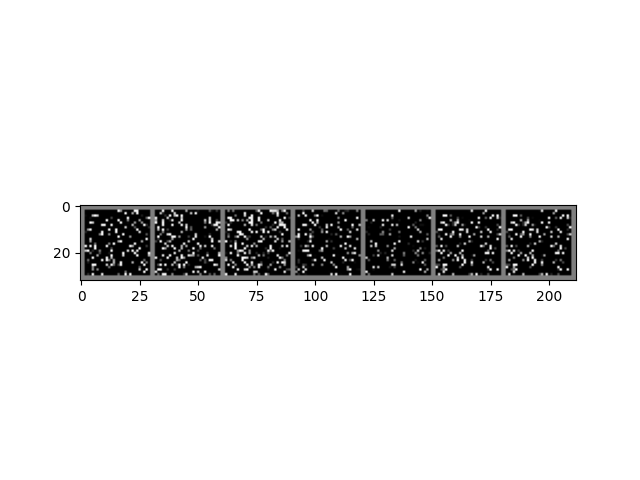

labels are: 4 0 6 5 4 9 9
MLP predictions are: 4 0 2 5 4 9 9
CNN predictions are: 4 0 0 5 4 9 9


In [ ]:
dataiter = iter(pixel_shuffle_test_loader)
images, labels = dataiter.next()
# images, labels = next(dataiter)

# Make a forward pass to get predictions of the MLP model
mlp_scores = mlp_model(images)
_, mlp_preds = torch.max(mlp_scores.data, 1)

# Make a forward pass to get predictions of the ConvNet model
conv_scores = conv_model(images)
_, conv_preds = torch.max(conv_scores.data, 1)

show_img_idx = np.random.randint(images.shape[0], size=7)
# show images
imshow(torchvision.utils.make_grid(images[show_img_idx]))
# print labels
print('labels are:', ' '.join('%d' % labels[j] for j in show_img_idx))
# print predictions
print('MLP predictions are:', ' '.join('%d' % mlp_preds[j] for j in show_img_idx))
print('CNN predictions are:', ' '.join('%d' % conv_preds[j] for j in show_img_idx))